# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

6213

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,6.213000e+03,6213.000000,6213.000000,6.213000e+03,5.990000e+03,6.213000e+03,5990.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000
mean,3.241772e+02,2.528730,0.984870,6.732199e+07,7.758961e+07,2.375876e+04,38414.392654,2892.452117,0.006921,2.032191,7.223724,0.006921
std,2.537449e+04,0.924041,0.122078,1.321553e+07,6.529438e+06,2.086008e+05,34287.237070,1672.507693,0.082911,1.397010,8.707997,0.082911
min,1.000000e+00,1.000000,0.000000,2.842880e+06,2.648738e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.406698e+07,7.297336e+07,1.521000e+03,13606.000000,1387.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.001298e+07,7.711780e+07,1.581000e+03,25063.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.543734e+07,8.379348e+07,1.892000e+03,53327.000000,4321.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,8.756619e+07,8.810570e+07,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

223

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

In [10]:
len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [11]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
5535,2,2,11-11-2014,24-02-2016,1,1521,3768.0,1214,0,2,3,0
2530,2,3,16-06-2014,26-07-2017,1,1556,28534.0,3700,0,3,15,0
3573,3,3,21-12-2011,22-03-2017,1,1503,64270.0,105,0,4,15,0
2037,2,3,23-08-2016,20-11-2017,1,1869,8046.0,3113,0,2,8,0
3102,2,3,02-09-2016,10-05-2017,1,3071,5990.0,3913,0,3,8,0
4989,2,2,09-03-2016,08-06-2016,1,1537,26482.0,3433,0,0,2,0
5464,2,2,10-12-2015,22-03-2016,1,3047,10297.0,810,0,0,2,0
2051,2,2,01-08-2017,31-10-2017,1,367,16170.0,689,0,1,2,0
1847,2,2,15-09-2017,07-02-2018,1,1766,15902.0,689,0,1,6,0
4420,2,3,13-10-2015,04-11-2016,1,1506,23992.0,5459,0,3,11,0


In [12]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,5.990000e+03,5990.000000,5990.000000,5.990000e+03,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000
mean,3.361636e+02,2.535058,0.985309,2.357373e+04,38414.392654,2898.332554,0.007012,2.045409,7.221870,0.007012
std,2.584250e+04,0.932175,0.120323,2.077185e+05,34287.237070,1669.009741,0.083449,1.394695,8.570688,0.083449
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13606.000000,1428.250000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.581000e+03,25063.000000,3083.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.892000e+03,53327.000000,4335.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [13]:
# tratando os nulos
df_work.fillna(-1, inplace=True)

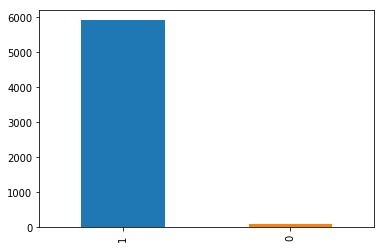

In [14]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [15]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [16]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

In [17]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
1187,2,3,2016-01-28,2018-05-18,1,1556,53309.0,3097,0,2,6,0,841
3068,2,3,2016-01-29,2017-05-12,1,1533,116506.0,4570,0,3,5,0,469
185,2,1,2018-03-04,2018-08-01,1,2007098,14143.0,3425,0,1,2,0,150
5489,2,2,2015-02-10,2016-03-09,1,1727,6894.0,3113,0,1,7,0,393
3072,2,3,2016-04-08,2017-05-22,1,1892,127558.0,301,0,1,2,0,409
2573,2,3,2015-07-31,2017-07-18,1,1102,12024.0,3685,0,4,62,0,718
1013,2,2,2017-11-28,2018-06-04,1,2086,5262.0,3573,0,2,4,0,188
1310,2,3,2016-01-09,2018-05-10,1,1556,127511.0,5441,0,2,5,0,852
2567,2,3,2016-10-25,2017-08-01,1,1753,17154.0,4313,0,2,3,0,280
1094,2,3,2014-06-02,2018-05-21,1,1772,29006.0,5055,0,5,11,0,1449


In [18]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
model.score(df_work[features], df_work['homologado'])

0.9986644407345576

In [20]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4492, 13), (1498, 13))

In [21]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [23]:
from sklearn.metrics import accuracy_score

def print_score():
    print(accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))

print_score()

0.9986642920747997 0.9799732977303071


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   28],
       [   2, 1468]])

In [25]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    2, 1468])

In [26]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(1470, 28)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 0 tn - *true negative*; ou seja, o modelo não conseguiu acertar nenhum dos que não tiveram o arquivamento homologado;
- tivemos 28 fp - *false positive*; 28 que não tiveram o arquivamento homologado e o modelo classificou como homologado;
- tivemos 2 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1468 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 22 que não foram homologados, o modelo errou todos e ainda marcou 4 não homologados de forma errada.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

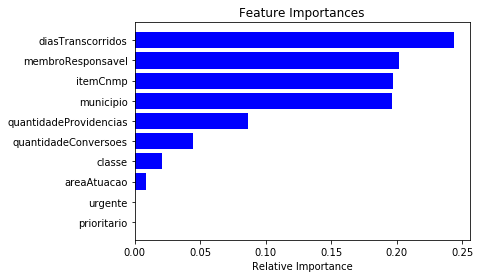

In [27]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [28]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

0.9984416740872663 0.9799732977303071


In [29]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    2, 1468])

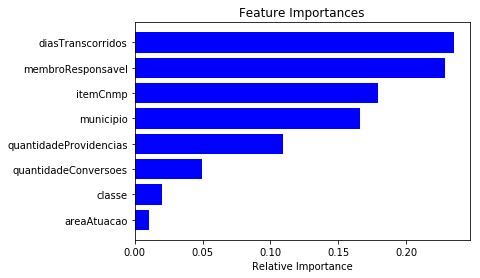

In [30]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [31]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

0.9984416740872663 0.9806408544726302


In [32]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    1, 1469])

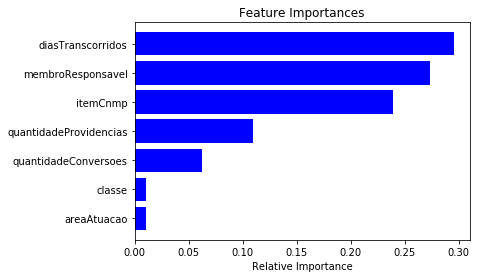

In [33]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, o desempenho melhorou um pouco - acurácia aumentou e os falses positivos diminuíram.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [34]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

0.9984416740872663 0.9806408544726302


In [35]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    1, 1469])

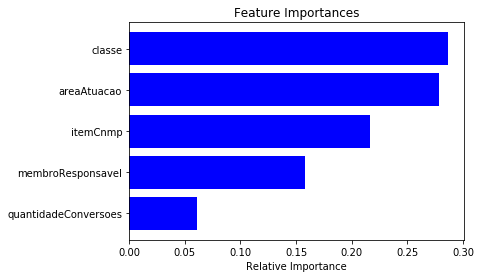

In [37]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se manteve (acurácia boa, mas muito ruim em lidar com os não homologados). 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [38]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

0.9884238646482636 0.979305740987984


In [39]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    3, 1467])

Com o modelo mais simples, o desempenho foi o pior de todos até agora. Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [53]:
df_work = df_original.copy()

df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
df_work.reset_index(drop=True, inplace=True)

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  (df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(-1, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
3990,2,3,1,3119,5990.0,3913,3,9,"Converta-se em Inquérito Civil(IC).,Junte-se.,...",57
1890,2,3,1,1863,127507.0,226,3,7,"Converta-se em Inquérito Civil(IC).,Oficie-se,...",614
3732,2,2,1,2359,4043.0,810,0,0,,34
1250,2,3,1,1503,9353.0,4081,0,2,"Análise do arquivamento,Certifica acatamento d...",418
2927,2,2,1,91,17863.0,5459,1,1,Converta-se em Procedimento Preparatório(PP).,112
2117,2,3,1,3150,127548.0,404,3,12,"Despacho Simplificado,Converta-se em Inquérito...",684
393,2,2,1,1874,64327.0,2742,2,6,"Oficie-se.,Prorroga-se o prazo de finalização ...",304
5079,2,2,1,1567,31553.0,5459,1,2,"Oficie-se,Converta-se em Procedimento Preparat...",98
5859,2,2,1,902,53295.0,2919,2,2,Prorroga-se o prazo de finalização do Procedim...,35
4808,5,3,1,1556,31430.0,1214,3,11,"Converta-se em Inquérito Civil(IC).,Sobrestar ...",813


In [55]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
len(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')
len(listaProvidencias)

66

In [56]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [57]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [58]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,reautue-se,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,analisar arquivamento,,análise do arquivamento
0,2,3,1,3078,53306.0,2733,1,3,"Despacho Simplificado,Converta-se em Inquérito...",279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2,3,1,1515,4575.0,4108,5,17,"Encaminhe-se o auto.,Analisar Arquivamento,Ofi...",1947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
2,2,3,1,1542,17795.0,5296,2,4,"Converta-se em Inquérito Civil(IC).,Oficie-se....",367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,2,3,1,3058,11396.0,3573,3,9,"Converta-se em Inquérito Civil(IC).,Analisar A...",1030,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
4,2,3,1,1521,53306.0,2561,1,2,"Converta-se em Inquérito Civil(IC).,Cumpra-se.",552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [59]:
df_work.fillna(-1, inplace=True)

In [60]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [61]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

0.9984416740872663 0.9806408544726302


In [63]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   28,    1, 1469])

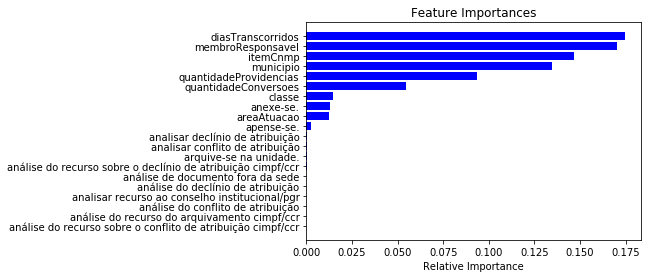

In [64]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes).

Agora vamos efetivamente utilizar o texto das íntegras.